# 问题描述

这里的数据集来自wiki语料库数据集，该数据集按照恶毒程度划分。该语料库包含了从2004年到2015年关于用户页面和文章的讨论中得出的6300万条评论。
不同的平台/网站对其恶毒程度的筛选可能有不同的标准。因此，注释标记为以下五个类别：
toxic
severe_toxic
obscene
threat
insult
identity_hate

标记是通过众包完成的，这意味着数据集是由不同的人进行评级的，标记也可能不是100%准确。

在这个项目中，需要解决的问题是文本分类，文本来自于Wikipedia’s talk page edits的评论。这是一个典型的自然语言处理问题，对于自然语言处理（NLP），有以下几种方法可以处理：

- Rule-based model
- Probabilistic modeling 和 machine learning
- Deep learning

在实际应用中，一般不会应用Rule-based方法，比较常用的是基于概率的机器学习和深度学习。所以在这次项目中，基于概率的机器学习和深度学习将会是重点。在Udacity给出的参考模型中只有第一个‘词袋模型 + LR 解决方案’是基于概率的机器学习，剩下都是深度学习，结合自然语言处理的应用现状，深度学习确实是比较热门的解决方案。

> - [词袋模型 + LR 解决方案](https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams)
> - [TextCNN 解决方案](https://www.kaggle.com/yekenot/textcnn-2d-convolution)
> - [LSTM + Attention 解决方案](https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043)
> - [GRU 解决方案](https://www.kaggle.com/prashantkikani/pooled-gru-with-preprocessing)
> - [GRU + CNN 解决方案](https://www.kaggle.com/konohayui/bi-gru-cnn-poolings)

# 数据或输入

数据包括人为标记的维基百科评论，这些评论按照恶毒程度分为了以下几个级别：

- `toxic`
- `severe_toxic`
- `obscene`
- `threat`
- `insult`
- `identity_hate`

项目提供的文件如下：

- **train.csv** - 训练集包括以二进制形式标记的标签
- **test.csv** -在测试集中，必须预测这些的评论恶毒程度的概率。为了阻止手工标记，测试集包含一些未包含在评分中的注释。
- **sample_submission.csv** - a sample submission file in the correct format
- **test_labels.csv** - 测试数据的标签；值为`-1`表示未用于评分；

这些数据会首先进行如下的处理：

- 数据探索：查看数据的情况，并做出初始分析。
- 数据处理：对文本数据做预处理并建立模型
- 训练：将处理好的模型导入机器学习或深度学习模型进行训练
- 提交

In [1]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#visualize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn

# 数据探索

In [2]:
#importing the dataset
train=pd.read_csv("./data/train.csv")
test=pd.read_csv("./data/test.csv")

In [3]:
#take a peak
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [10]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 159571 : 153164
perc   : 51    : 49


In [11]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [12]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)
test["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64
filling NA with "unknown"


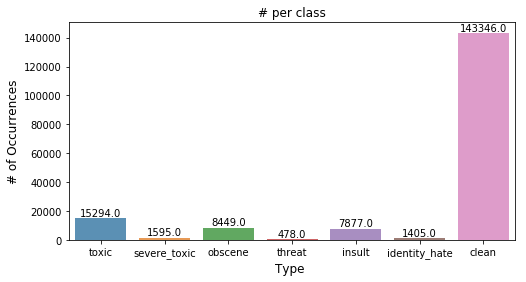

In [18]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# 数据预处理

In [4]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/qizichen1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
X_train = train["comment_text"]
y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
X_test = test["comment_text"]

In [6]:
X_train.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [8]:
y_train.tail()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0
159570,0,0,0,0,0,0


In [9]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()# lowercase text
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(BAD_SYMBOLS_RE,'',text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)# delete stopwords from text
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"i’m", "i am", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    return text

In [10]:
train_text = []
test_text = []
for text in X_train:
    train_text.append(text_prepare(text))
    
for text in X_test:
    test_text.append(text_prepare(text))

In [11]:
from sklearn.model_selection import train_test_split
X_tra, X_val, y_tra, y_val = train_test_split(train_text, y_train, train_size=0.95, random_state=233)


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
def tfidf_word_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    
    tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=20000) 
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test

In [14]:
def tfidf_char_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    
    tfidf_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    ngram_range=(1, 6),
    max_features=30000)
    X_train = tfidf_vectorizer.fit_transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    return X_train, X_val, X_test

In [15]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
X_train_word, X_val_word, X_test_word = tfidf_word_features(X_tra, X_val, X_test)
X_train_char, X_val_char, X_test_char = tfidf_char_features(X_tra, X_val, X_test)

In [16]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    clf = OneVsRestClassifier(LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None)
    clf.fit(X_train, y_train)
    return clf

In [23]:
classifier_word = train_classifier(X_train_word, y_tra)
classifier_char = train_classifier(X_train_char, y_tra)

In [27]:
y_val_predicted_labels_word = classifier_word.predict(X_val_word)
y_val_predicted_labels_char = classifier_char.predict(X_val_char)

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [29]:
def print_evaluation_scores(y_val, predicted):
    print(accuracy_score(y_val, predicted))
    print(f1_score(y_val, predicted, average='weighted'))
    print(average_precision_score(y_val, predicted))

In [30]:
print('N-gram on word')
print_evaluation_scores(y_val, y_val_predicted_labels_word)
print('N-gram on characters')
print_evaluation_scores(y_val, y_val_predicted_labels_char)

N-gram on word
0.915026945732548
0.7103862611244274
0.3973969088169386
N-gram on characters
0.9142749718009776
0.7156656364047917
0.39406540089034814


In [39]:
from sklearn.metrics import roc_auc_score
%matplotlib inline
print('N-gram on word')
roc_auc_score(y_val, y_val_predicted_labels_word)


N-gram on word


0.7416484892952914

In [38]:
print('N-gram on characters')
roc_auc_score(y_val, y_val_predicted_labels_char)

N-gram on characters


0.7372848462346845

In [102]:
y_test_predicted_proba_word = classifier_word.predict_proba(X_test_word)

In [134]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
feature = pd.DataFrame(y_test_predicted_labels_word, columns= class_names)
id = pd.DataFrame.from_dict({'id': test['id']})

In [137]:
submission = pd.concat([id, feature],axis = 1)

In [138]:
submission.to_csv('Logistic-Submission.csv', index=False)